In [ ]:
%matplotlib inline
%config InlineBackend.figure_format ='retina'
import seaborn as sns
import matplotlib.pyplot as plt

sns.set()

In [ ]:
import numpy as np
from sklearn.decomposition import PCA
from tqdm.autonotebook import trange

slide N18 from lecture about PCA algorithm:


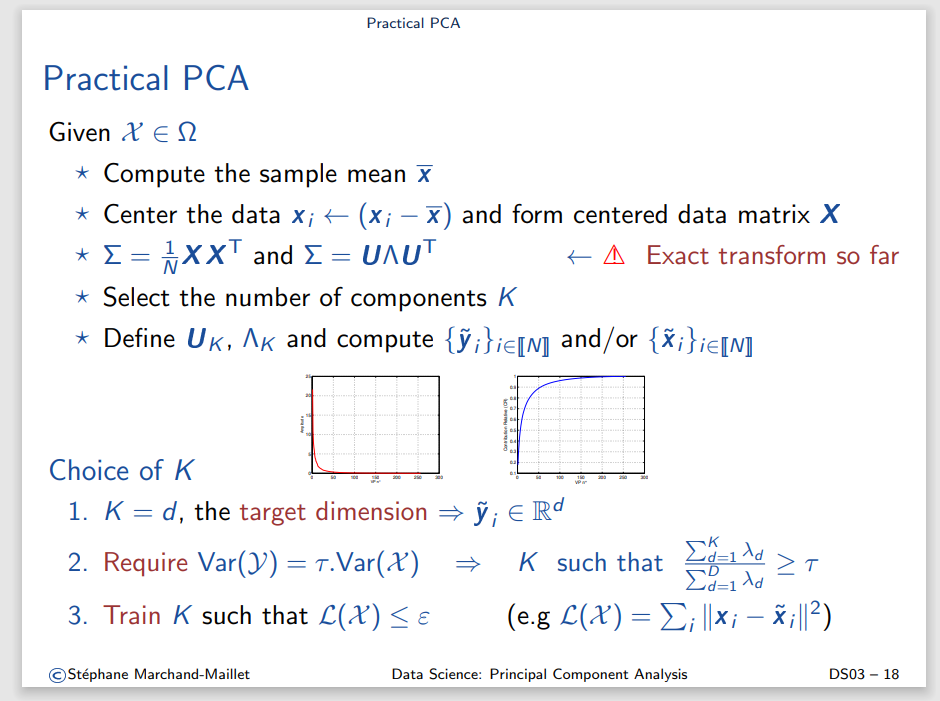

# Part 1: PCA calculation step by step

Step 1: Get your data

In [ ]:
X = np.array([(2, 1), (3, 5), (4, 3),
              (5, 6), (6, 7), (7, 8)])
X, X.shape

In [ ]:
plt.scatter(X[:, 0], X[:, 1])
plt.title("Original data")
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal');

Step 2: Center your data

In [ ]:
mu = np.mean(X, axis=0)  # compute mean
mu

In [ ]:
assert mu[1] == (1 + 5 + 3 + 6 + 7 + 8) / 6

In [ ]:
A = X - mu # substract mean from data
A

In [ ]:
np.mean(A, axis=0)

In [9]:
assert np.allclose(np.mean(A, axis=0), 0)

Step 3: Get Covariance of A

In [10]:
cov = np.cov(X, rowvar=False) # compute covariance
cov

array([[3.5, 4.4],
       [4.4, 6.8]])

In [11]:
assert cov.shape == (2, 2), 'covariance of two features should by 2x2 matrix'
assert np.all(np.linalg.eigvals(cov) >= 0) and np.array_equal(cov,
                                                              cov.T), 'covariance should b positive semidefinite matrix'

Step 4: Calculate Eigen Vectors and Eigen Values

In [12]:
values, vectors = np.linalg.eigh(cov) # find values and vectors

In [13]:
values, vectors

(array([0.45079794, 9.84920206]),
 array([[-0.82192562,  0.56959484],
        [ 0.56959484,  0.82192562]]))

The second one should be much more important.

Step 5: Sort values and vectors descending

In [14]:
index = np.argsort(values)[::-1] 
values, vectors = values[index], vectors[:, index] # sort by importance
values, vectors

(array([9.84920206, 0.45079794]),
 array([[ 0.56959484, -0.82192562],
        [ 0.82192562,  0.56959484]]))

Plot Explained Variance

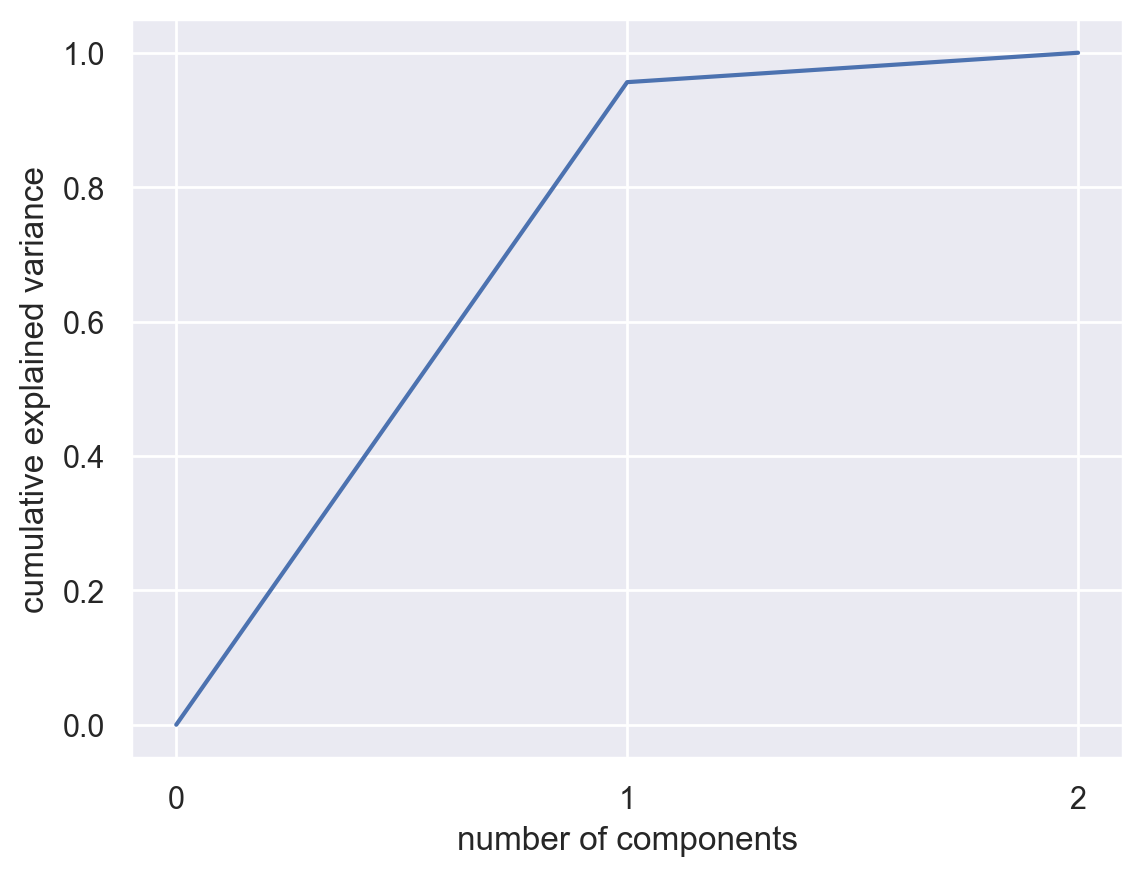

In [15]:
plt.plot(np.concatenate([[0], np.cumsum(values / values.sum())]))
plt.gca().xaxis.get_major_locator().set_params(integer=True)
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance');

Step 6: Calculate the transformation using all vectors initially

In [16]:
P = np.dot(A, vectors)
P

array([[-4.71168956, -0.22356531],
       [-0.85439226,  1.23288843],
       [-1.92864865, -0.72822687],
       [ 1.10672304,  0.15863203],
       [ 2.49824349, -0.09369875],
       [ 3.88976395, -0.34602953]])

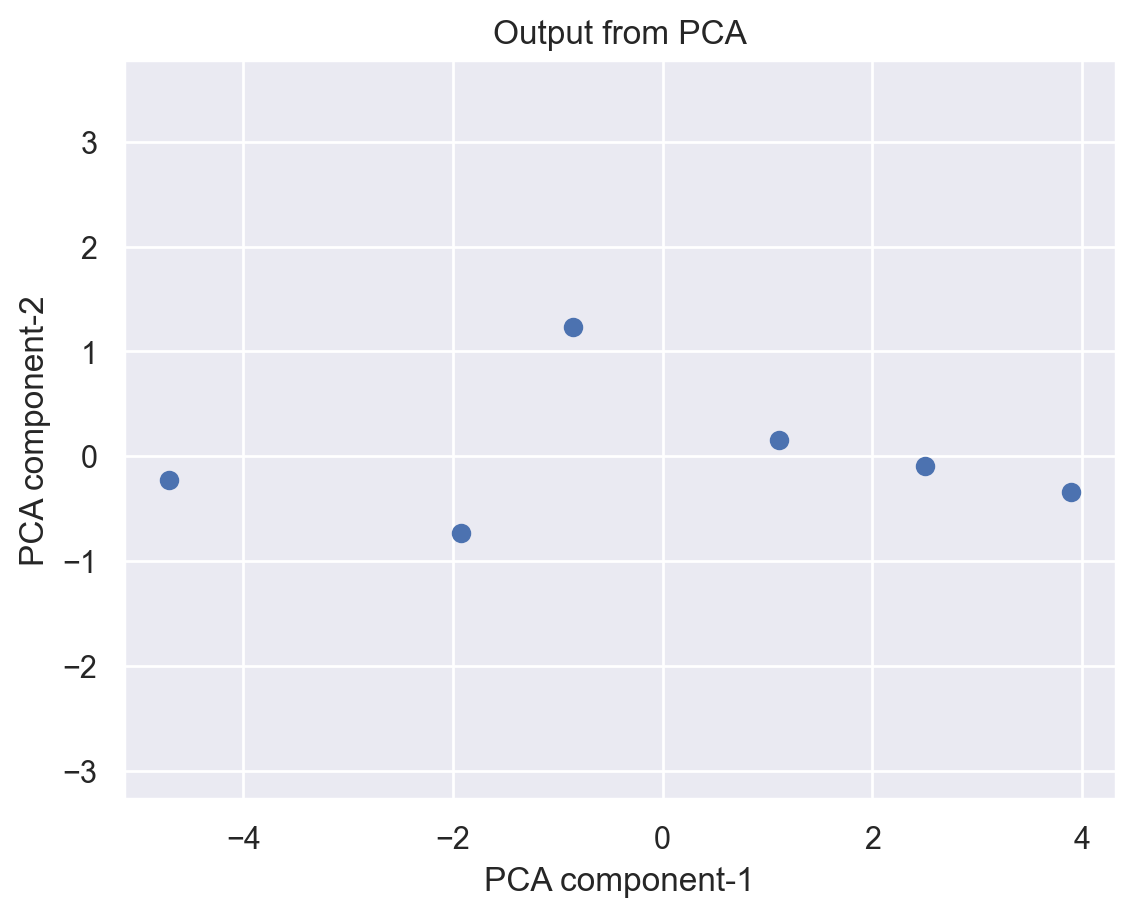

In [17]:
plt.scatter(P[:, 0], P[:, 1])
plt.title("Output from PCA")
plt.xlabel('PCA component-1')
plt.ylabel('PCA component-2')
plt.axis('equal');

Step 7: select only from the biggest eigen value

In [18]:
component_1 = P[:, 0]
component_1

array([-4.71168956, -0.85439226, -1.92864865,  1.10672304,  2.49824349,
        3.88976395])

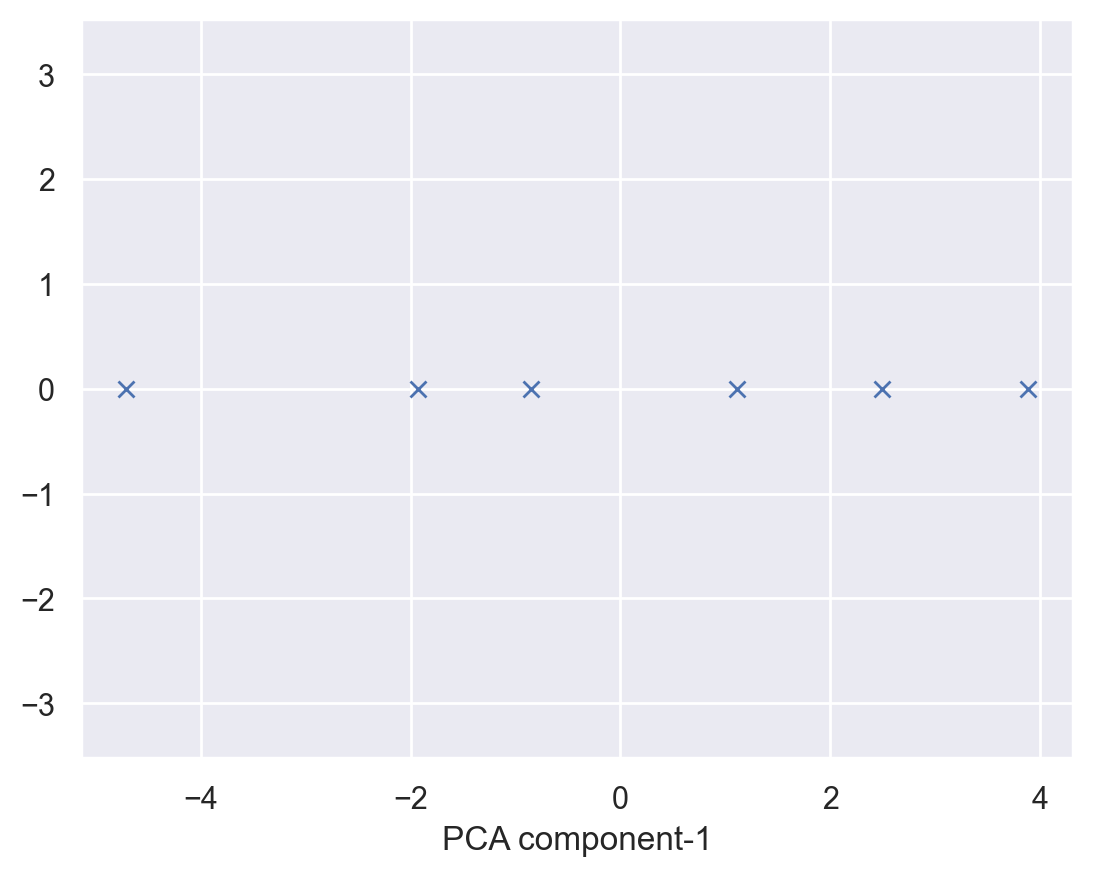

In [19]:
plt.plot(component_1, np.zeros_like(component_1), 'x')
plt.xlabel('PCA component-1')
plt.axis('equal');

Step 8: select only from the smallest eigen value (for debug only)

In [20]:
component_2 = P[:, 1]

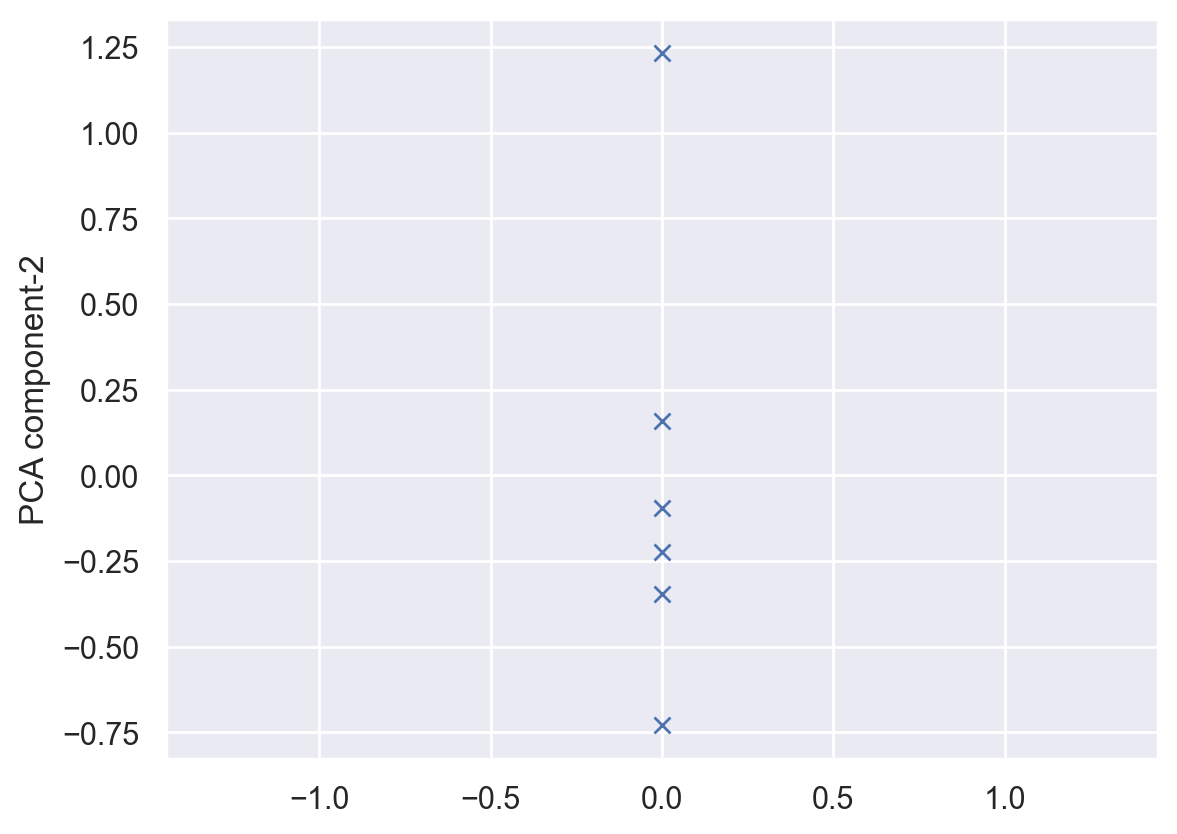

In [21]:
plt.plot(np.zeros_like(component_2), component_2, 'x')
plt.ylabel('PCA component-2')
plt.axis('equal');

### Compare with sklearn

In [22]:
from sklearn.decomposition import PCA

pca = PCA(n_components=1, svd_solver='full')

In [23]:
pca.fit(X)

PCA(n_components=1, svd_solver='full')

In [24]:
pca.mean_

array([4.5, 5. ])

In [25]:
assert np.allclose(pca.mean_, mu)

In [26]:
pca.get_covariance()

array([[3.5, 4.4],
       [4.4, 6.8]])

In [27]:
assert np.allclose(pca.get_covariance(), cov)

In [28]:
R = pca.transform(X)
R

array([[-4.71168956],
       [-0.85439226],
       [-1.92864865],
       [ 1.10672304],
       [ 2.49824349],
       [ 3.88976395]])

In [29]:
L = component_1.reshape(-1, 1)
assert np.allclose(R, L)

They are the same!

In [30]:
pca.inverse_transform(pca.transform(X))

array([[1.81624595, 1.12734164],
       [4.01334258, 4.29775312],
       [3.40145168, 3.41479426],
       [5.13038373, 5.90964402],
       [5.9229866 , 7.05337032],
       [6.71558946, 8.19709663]])

### Conclusion of the first part

To compute PCA you need to do the following:
* Compute the mean for every dimension of the whole dataset.
* Compute the covariance matrix of the whole dataset.
* Compute eigenvectors and the corresponding eigenvalues.
* Sort the eigenvectors by decreasing eigenvalues and choose k eigenvectors with the largest eigenvalues to form a d × k dimensional matrix W.
* Use this d × k eigenvector matrix to transform the samples onto the new subspace.

[source](https://towardsdatascience.com/the-mathematics-behind-principal-component-analysis-fff2d7f4b643)

Steps from [here](https://iq.opengenus.org/algorithm-principal-component-analysis-pca/)

Or you can just use `sklearn` library (much cleaner, faster, ...)

# Part 2: PCA calculation via single class

You've successfully implemented PCA calculation step-by-step. Congratulations!

Now you need to combine your solution in a single class, based on `sklearn` interface. To know more about the interface refer to the [documentation](https://scikit-learn.org/stable/developers/develop.html#rolling-your-own-estimator).

In this section you need to implement `__init__`, `fit`, `transform` and `inverse_transform` methods.

Then you need to launch the next cell to test correctness of your class.

In [31]:
from sklearn.base import TransformerMixin, BaseEstimator

In [32]:
class CustomPCA(TransformerMixin, BaseEstimator):
    def __init__(self, n_components):
        self.n_components = n_components

    def fit(self, X):
        """
        Fit the model with X.
        """
        self.mean_ = np.mean(X, axis=0)
        A = X - self.mean_

        # Compute covariance matrix
        cov = np.cov(A, rowvar=False)

        # Compute eigenvalues and eigenvectors
        eig_values, eig_vectors = np.linalg.eigh(cov)

        # Sort eigenvalues and eigenvectors
        sorted_indices = np.argsort(eig_values)[::-1]
        self.eig_values_ = eig_values[sorted_indices]
        self.eig_vectors_ = eig_vectors[:, sorted_indices]

        # Select a subset of the eigenvectors (principal components)
        self.eig_vectors_ = self.eig_vectors_[:, :self.n_components]

        return self

    def transform(self, X):
        """
        Apply dimensionality reduction to X.
        """
        A = X - self.mean_
        return np.dot(A, self.eig_vectors_)
        

    def inverse_transform(self, X):
        """
        Transform data back to its original space.
        """
        return np.dot(X, self.eig_vectors_.T) + self.mean_

In [33]:
### some utility code ###

SAMPLES_MIN, SAMPLES_MAX = 5, 10000
FEATURES_MIN, FEATURES_MAX = 2, 300


def generate_random_matrix(rng, n_samples=None, n_features=None):
    if n_samples is None:
        n_samples = rng.randint(SAMPLES_MIN, SAMPLES_MAX + 1)
    if n_features is None:
        n_features = rng.randint(FEATURES_MIN, FEATURES_MAX + 1)
    random_type = rng.randint(2)
    if random_type == 0:
        # uniform distribution
        low, high = rng.rand(2) * 100
        low, high = min(low, high), max(low, high)
        return rng.uniform(low, high, (n_samples, n_features)).astype(np.float64)
    # normal distribution
    loc, scale = rng.rand(2) * 100
    return rng.normal(loc, scale, (n_samples, n_features)).astype(np.float64)


def check_pca(X, custom_pca, sklearn_pca, matrix_name=''):
    custom_transform = custom_pca.transform(X)
    sklearn_transform = sklearn_pca.transform(X)
    assert np.all(np.isclose(custom_transform - sklearn_transform, 0) | np.isclose(custom_transform + sklearn_transform,
                                                                                   0)), f'pca transform does not equal with sklearn for {matrix_name} matrix'

    custom_inverse_transform = custom_pca.inverse_transform(custom_transform)
    sklearn_inverse_transform = sklearn_pca.inverse_transform(sklearn_transform)

    assert np.allclose(custom_inverse_transform,
                       sklearn_inverse_transform), f'pca inverse transform does not equal with sklearn for {matrix_name} matrix'

In [34]:
%%time
rng = np.random.RandomState(42)
N_RETRIES = 20
N_DIFFERENT_COMPONENTS = 2
N_DIFFERENT_MATRICIES = 2

for _ in trange(N_RETRIES):
    X = generate_random_matrix(rng)
    n_samples, n_features = X.shape

    for n_components in rng.choice(range(1, n_features + 1), min(N_DIFFERENT_COMPONENTS, n_features), replace=False):
        custom_pca = CustomPCA(n_components=n_components).fit(X)
        sklearn_pca = PCA(n_components=n_components, svd_solver='full').fit(X)

        check_pca(X, custom_pca, sklearn_pca, 'original')

        for _ in range(N_DIFFERENT_MATRICIES):
            Y = generate_random_matrix(rng, n_features=n_features)
            check_pca(Y, custom_pca, sklearn_pca, 'different')

  0%|          | 0/20 [00:00<?, ?it/s]

CPU times: user 22 s, sys: 5.93 s, total: 27.9 s
Wall time: 14.2 s
